In [1]:
# We are going to explore clustering as a semi-supervised learning technique.
# In this example, we will train a Logistic Regression model using only a small subset (50 samples)
# of labeled data from the digits dataset and evaluate its performance.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits

# Load the digits dataset
# X_digits contains the image data (each image is 8x8 pixels flattened to 64 features)
# y_digits contains the corresponding digit labels (0 to 9)
X_digits, y_digits = load_digits(return_X_y=True)

# Split the dataset into training and testing sets
# By default, 75% of the data is used for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

# Define the number of labeled instances to use for training
n_labeled = 50

# Create and train a Logistic Regression model on only the first 50 labeled training samples
log_reg = LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

# Evaluate and print the accuracy of the model on the full test set
print(f"The accuracy of the Logistic Regressor is: {log_reg.score(X_test, y_test):.4f}")

The accuracy of the Logistic Regressor is: 0.8267


  File "d:\hands_on_machine_learning\C9 - Unsupervised Learning Techniques\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


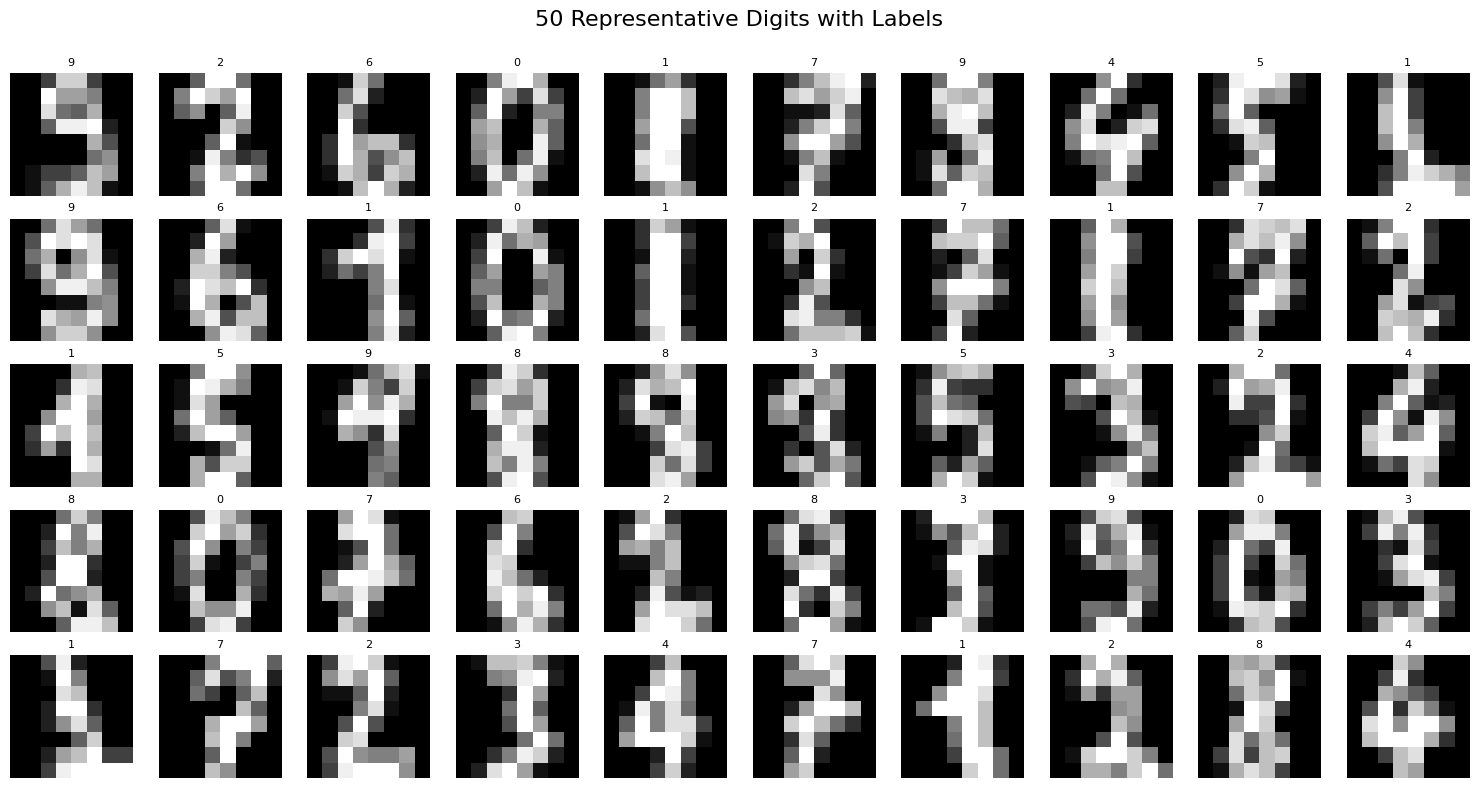

In [2]:
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Suppress convergence warnings
warnings.filterwarnings("ignore")

k = 50  # Number of clusters

# Fit KMeans on the training set
kmeans = KMeans(n_clusters=k, random_state=42)
X_train_dist = kmeans.fit_transform(X_train)  # Only use X_train

# For each cluster, find the index (in X_train) of the point closest to the centroid
representative_digit_idx = np.argmin(X_train_dist, axis=0)

# Extract the representative samples and their labels
X_representative_digits = X_train[representative_digit_idx]
y_representative_digits = y_train[representative_digit_idx]

# ---- OPTIONAL: Plot the representative digits ----
plt.figure(figsize=(15, 8))
for idx, (flattened_image, label) in enumerate(zip(X_representative_digits, y_representative_digits)):
    plt.subplot(5, 10, idx + 1)
    # Reshape 64-length vector into 8x8 image for plotting
    image = flattened_image.reshape(8, 8)
    plt.imshow(image, cmap="gray", interpolation='nearest')
    plt.axis("off")
    plt.title(f"{label}", fontsize=8)

plt.suptitle("50 Representative Digits with Labels", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [3]:
# Flatten the 8x8 representative images to 64 features for training
X_flat = X_representative_digits.reshape(len(X_representative_digits), -1)

# Train logistic regression on representative digits
log_reg = LogisticRegression()
log_reg.fit(X_flat, y_representative_digits)

# Evaluate
print(f"The accuracy of the Logistic Regressor is: {log_reg.score(X_test, y_test):.4f}")

The accuracy of the Logistic Regressor is: 0.9156


In [4]:
# What if we propagate the labels to all the other instances in the same cluster?
# This is called label propagation

# Create an empty array to hold the propagated labels for each training sample
# We'll fill this with the label of the representative digit of each cluster
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

# For each cluster (i from 0 to k-1)
for i in range(k):
    # Assign the representative label (from y_representative_digits[i]) to
    # all samples in the training set that belong to cluster i
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [5]:
# Now let's train the model again and look at its performance
# Create a new Logistic Regression model
log_reg = LogisticRegression()

# Train the model on the entire training set using the propagated (pseudo) labels
log_reg.fit(X_train, y_train_propagated)

# Evaluate the model on the real test set and print the accuracy
# Note: We're still using the original test labels (y_test) for evaluation
print(f"The new accuracy of the Logistic Regressor is: {log_reg.score(X_test, y_test):.4f}")


The new accuracy of the Logistic Regressor is: 0.9244


In [6]:
# We have a reasonable accuracy boost. The problem is that we propagated each representative instance's label
# to all the instances in the same cluster, including the instances located close to the cluster boundaries,
# which are more likely to be mislabeled
# Let's see what happens if we only propagate the labels to the 20% of the instances that are closest to the centroid

percentile_closest = 20  # Keep only the closest 20% of points per cluster for label propagation

# Get the distance of each training sample to its assigned cluster center
X_cluster_dist = X_train_dist[np.arange(len(X_train)), kmeans.labels_]

# For each cluster...
for i in range(k):
    # Mask to select samples belonging to cluster i
    in_cluster = (kmeans.labels_ == i)

    # Get the distances of those samples to their cluster center
    cluster_dist = X_cluster_dist[in_cluster]

    # Define the cutoff distance to retain only the closest 'percentile_closest'% of samples
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)

    # Identify samples in the cluster that are farther than the cutoff
    above_cutoff = (X_cluster_dist > cutoff_distance)

    # Mark them as unreliable by setting their distance to -1
    X_cluster_dist[in_cluster & above_cutoff] = -1  # <- assignment, not comparison

# Keep only the samples that were not marked as unreliable
partially_propagated = (X_cluster_dist != -1)

# Select the corresponding reliable training data and labels
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [7]:
# Now let's train the model again on this partially propagated dataset:
# Create a new Logistic Regression model
log_reg = LogisticRegression()

# Train the model using only the samples that were confidently labeled 
# (i.e., those closest to the cluster centers based on label propagation)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

# Evaluate the trained model on the test set and print the accuracy
print(f"The improved accuracy of the Logistic Regressor is: {log_reg.score(X_test, y_test):.4f}")

The improved accuracy of the Logistic Regressor is: 0.9133


In [8]:
# Compute the proportion of propagated labels that match the true labels
# This helps measure the quality of label propagation (how accurate it was)
match_ratio = np.mean(y_train_partially_propagated == y_train[partially_propagated])
print(f"Label propagation accuracy on selected samples: {match_ratio:.4f}")

Label propagation accuracy on selected samples: 0.9863
